In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cityblock
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [3]:
NO2=pd.read_csv("NO2_E43.csv")
NO2.rename(columns = {'mg/m^3_43':'mg/m^3'}, inplace = True)
NO2

,DATETIME,mg/m^3
0,2019-06-01 01:00:00,81.0
1,2019-06-01 02:00:00,67.0
2,2019-06-01 03:00:00,27.0
3,2019-06-01 04:00:00,23.0
4,2019-06-01 05:00:00,34.0
...,...,...
25891,2022-05-31 20:00:00,78.0
25892,2022-05-31 21:00:00,77.0
25893,2022-05-31 22:00:00,43.0
25894,2022-05-31 23:00:00,32.0


In [4]:
NO2.describe()

,mg/m^3
count,24903.000000
mean,40.011565
std,21.961829
min,1.000000
25%,23.000000
50%,36.000000
75%,53.000000
max,207.000000


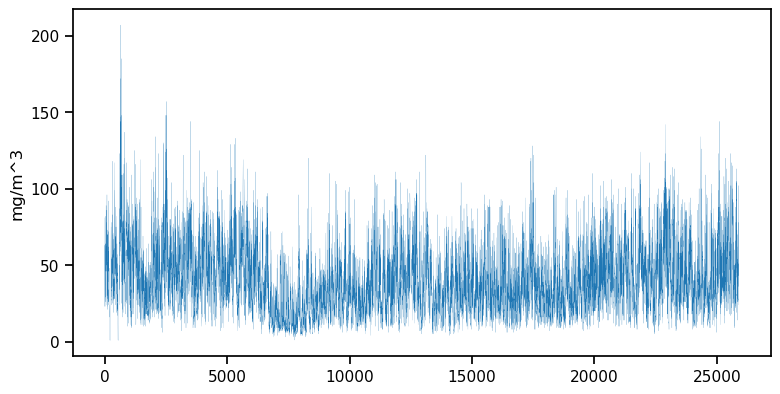

In [5]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=NO2["mg/m^3"],linewidth=.1)
plt.show()

## Missing values analysis

In [6]:
# % of missing values
NO2.count()/len(NO2)

DATETIME    1.000000
mg/m^3      0.961654
dtype: float64

In [7]:
NO2[ "mg/m^3_acum_NAN"]= 0

for j in range(1,len(NO2)):

    if NO2["mg/m^3"].isna()[j] == True :
        NO2[ "mg/m^3_acum_NAN"][j] =   NO2[ "mg/m^3_acum_NAN"][j-1]+1   
        
        
    else:
        NO2[ "mg/m^3_acum_NAN"][j] = 0

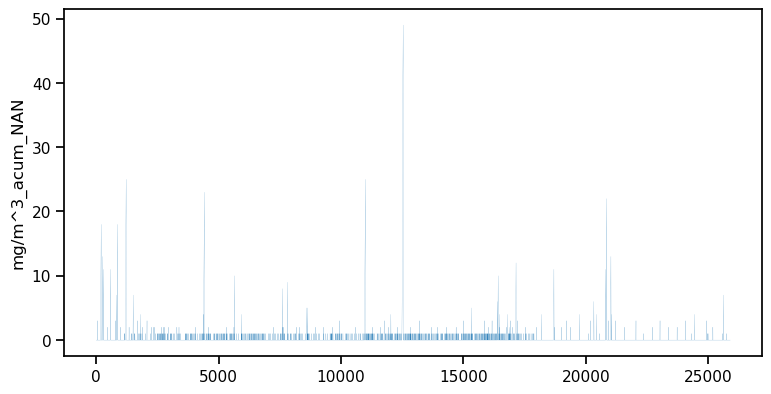

In [8]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=NO2["mg/m^3_acum_NAN"],linewidth=.1)
plt.show()

In [9]:
NO2[ "mg/m^3_peaks_acum_NAN"]= NO2[ "mg/m^3_acum_NAN"]


for j in range(1,len(NO2)):

    if (NO2["mg/m^3_acum_NAN"][j] == 0) or (NO2["mg/m^3_acum_NAN"][j+1] > 0) :
          
        NO2[ "mg/m^3_peaks_acum_NAN"][j] = 0

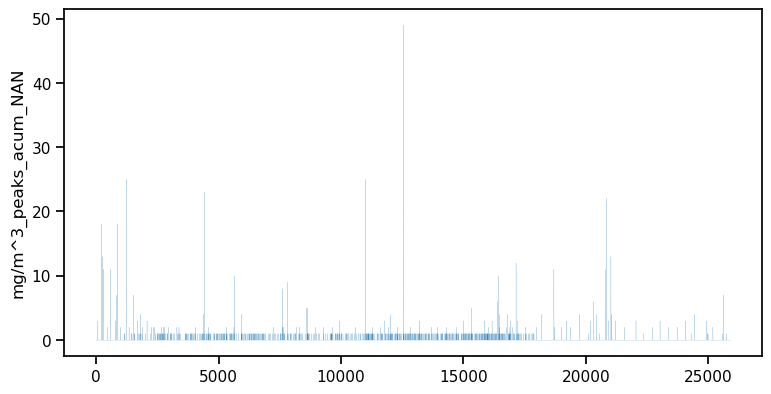

In [10]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=NO2["mg/m^3_peaks_acum_NAN"],linewidth=.1)
plt.show()

In [11]:
NO2["mg/m^3_peaks_acum_NAN"].value_counts().sort_index()

0     25348
1       440
2        51
3        20
4        11
5         3
6         2
7         3
8         1
9         1
10        2
11        4
12        1
13        2
18        2
22        1
23        1
25        2
49        1
Name: mg/m^3_peaks_acum_NAN, dtype: int64

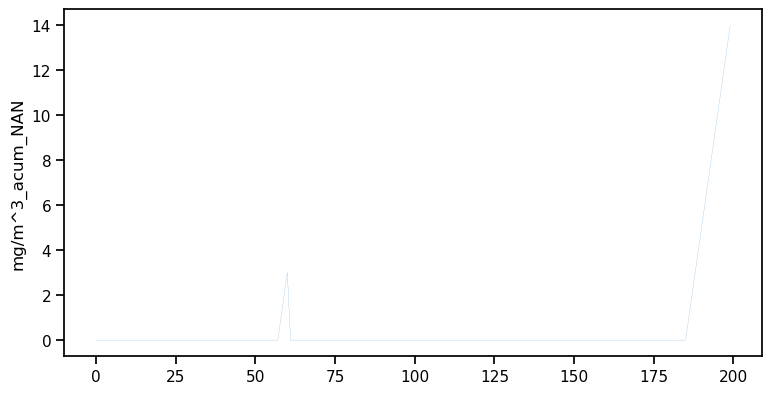

In [12]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=NO2[:200]["mg/m^3_acum_NAN"],linewidth=.1)
plt.show()

In [13]:
NO2["mg/m^3_im"] = NO2["mg/m^3"].fillna(NO2["mg/m^3"].mean())
NO2

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im
0,2019-06-01 01:00:00,81.0,0,0,81.0
1,2019-06-01 02:00:00,67.0,0,0,67.0
2,2019-06-01 03:00:00,27.0,0,0,27.0
3,2019-06-01 04:00:00,23.0,0,0,23.0
4,2019-06-01 05:00:00,34.0,0,0,34.0
...,...,...,...,...,...
25891,2022-05-31 20:00:00,78.0,0,0,78.0
25892,2022-05-31 21:00:00,77.0,0,0,77.0
25893,2022-05-31 22:00:00,43.0,0,0,43.0
25894,2022-05-31 23:00:00,32.0,0,0,32.0


# 24 h mean analysis

In [14]:
NO2["mg/m^3_im_24h"] = np.nan

for j in range(23, len(NO2)):

    NO2[ "mg/m^3_im_24h"][j] = NO2["mg/m^3_im"][j-23:j+1].mean()
    
NO2

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im,mg/m^3_im_24h
0,2019-06-01 01:00:00,81.0,0,0,81.0,NaN
1,2019-06-01 02:00:00,67.0,0,0,67.0,NaN
2,2019-06-01 03:00:00,27.0,0,0,27.0,NaN
3,2019-06-01 04:00:00,23.0,0,0,23.0,NaN
4,2019-06-01 05:00:00,34.0,0,0,34.0,NaN
...,...,...,...,...,...,...
25891,2022-05-31 20:00:00,78.0,0,0,78.0,53.958333
25892,2022-05-31 21:00:00,77.0,0,0,77.0,55.708333
25893,2022-05-31 22:00:00,43.0,0,0,43.0,55.583333
25894,2022-05-31 23:00:00,32.0,0,0,32.0,54.958333


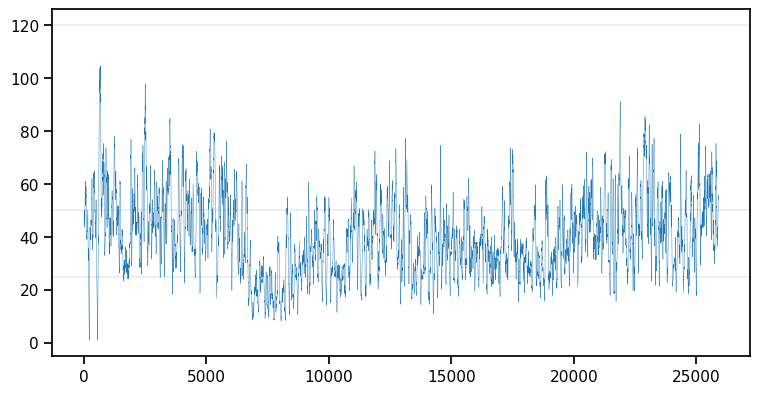

In [15]:
plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#graph = sns.lineplot(data=NO2["mg/m^3_43_24h"],linewidth=.1)

graph = plt.plot(NO2["mg/m^3_im_24h"],linewidth=.3)

plt.axhline(y=120,linewidth=.15)
plt.axhline(y=50,linewidth=.15)
plt.axhline(y=25,linewidth=.15)


plt.show()

In [19]:
NO2["AQG"] = np.nan

for j in range(len(NO2)):
    if NO2[ "mg/m^3_im_24h"][j]<= 25:
        NO2["AQG"][j] = "+"
    elif 25<NO2[ "mg/m^3_im_24h"][j]<= 50:
        NO2["AQG"][j] = "I1"
    elif 50<NO2[ "mg/m^3_im_24h"][j]<= 120:
        NO2["AQG"][j] = "I2"
    elif NO2[ "mg/m^3_im_24h"][j]> 120:
        NO2["AQG"][j] = "-"    

    
    
NO2["AQG"].value_counts()

I1    15764
I2     6142
+      3967
Name: AQG, dtype: int64

# 1y mean analysis

In [15]:
NO2["mg/m^3_im_1y"] = np.nan

for j in range(8759, len(NO2)):

    NO2[ "mg/m^3_im_1y"][j] = NO2["mg/m^3_im"][j-8759:j+1].mean()
    
NO2

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im,mg/m^3_im_24h,mg/m^3_im_1y
0,2019-06-01 01:00:00,81.0,0,0,81.0,NaN,NaN
1,2019-06-01 02:00:00,67.0,0,0,67.0,NaN,NaN
2,2019-06-01 03:00:00,27.0,0,0,27.0,NaN,NaN
3,2019-06-01 04:00:00,23.0,0,0,23.0,NaN,NaN
4,2019-06-01 05:00:00,34.0,0,0,34.0,NaN,NaN
...,...,...,...,...,...,...,...
25891,2022-05-31 20:00:00,78.0,0,0,78.0,53.958333,42.502855
25892,2022-05-31 21:00:00,77.0,0,0,77.0,55.708333,42.507764
25893,2022-05-31 22:00:00,43.0,0,0,43.0,55.583333,42.508677
25894,2022-05-31 23:00:00,32.0,0,0,32.0,54.958333,42.508906


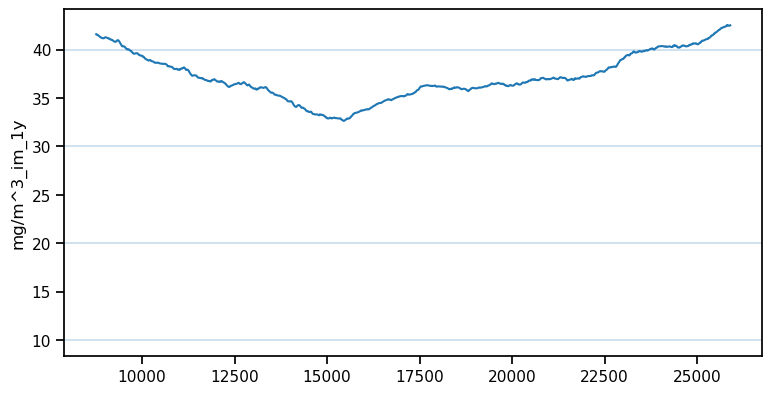

In [16]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
graph = sns.lineplot(data=NO2["mg/m^3_im_1y"])

graph.axhline(10,linewidth=.3)
graph.axhline(20,linewidth=.3)
graph.axhline(30,linewidth=.3)
graph.axhline(40,linewidth=.3)

plt.show()

## ARIMA forecasting

In [17]:
size = int(len(NO2["mg/m^3_im"])*.8)

train, test = NO2["mg/m^3_im"].iloc[:size], NO2["mg/m^3_im"].iloc[size:]

In [18]:
step_fit = auto_arima(NO2["mg/m^3_im"],trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=196828.770, Time=70.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=199626.875, Time=1.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=199590.259, Time=1.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=199583.104, Time=6.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=199624.876, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=196968.137, Time=31.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=196901.684, Time=34.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=196831.324, Time=71.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=196830.074, Time=80.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=19.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=196883.760, Time=37.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=196849.276, Time=44.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=196831.332, Time=62.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=196826.770, Time=13.59 sec
 A

In [19]:
step_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                25896
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -98408.385
Date:                Tue, 05 Jul 2022   AIC                         196826.770
Time:                        16:33:27   BIC                         196867.579
Sample:                             0   HQIC                        196839.956
                              - 25896                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2787      0.026     49.351      0.000       1.228       1.330
ar.L2         -0.4551      0.021    -22.131      0.000      -0.495      -0.415
ma.L1         -1.3413      0.027    -48.881      0.000      -1.395      -1.288
ma.L2          0.3694      0.027     13.853      0.000       0.317       0.422
sigma2       117.0566      0.681    171.976      0.000     115.722     118.391
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             10075.52
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
model = ARIMA(NO2["mg/m^3_im"],order=(2,1,2))
model = model.fit(method='mle')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mg/m^3_im   No. Observations:                25895
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -98408.385
Method:                           mle   S.D. of innovations             10.819
Date:                Tue, 05 Jul 2022   AIC                         196828.770
Time:                        16:34:18   BIC                         196877.741
Sample:                             1   HQIC                        196844.594
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0002      0.011     -0.019      0.985      -0.021       0.021
ar.L1.D.mg/m^3_im     1.2790      0.033     39.217      0.000       1.215       1.343
ar.L2.D.mg/m^3_im    -0.4553      0.027    -17.166      0.000      -0.507      -0.403
ma.L1.D.mg/m^3_im    -1.3416      0.035    -38.786      0.000      -1.409      -1.274
ma.L2.D.mg/m^3_im     0.3697      0.034     10.776      0.000       0.302       0.437
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4045           -0.4730j            1.4820           -0.0517
AR.2            1.4045           +0.4730j            1.4820            0.0517
MA.1            1.0481           +0.0000j            1.0481            0.0000
MA.2            2.5809           +0.0000j            2.5809            0.0000
-----------------------------------------------------------------------------
"""

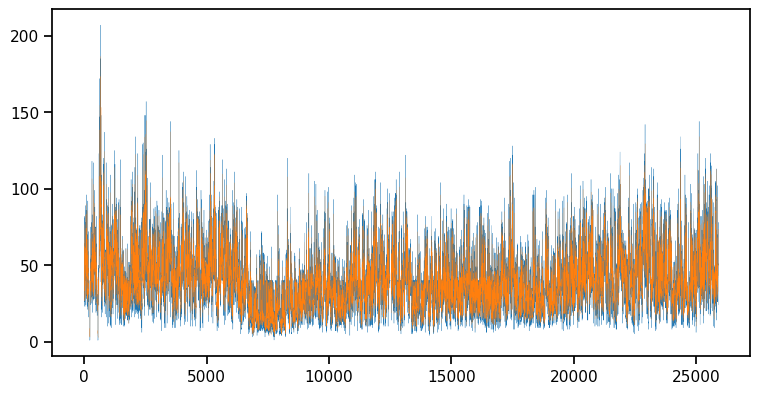

In [21]:
pred=model.predict(typ='levels')
plt.figure(figsize=(9,4.5))


plt.plot(NO2["mg/m^3_im"], linewidth =.2)
plt.plot(pred, linewidth=.1)
plt.show()

In [22]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(pred,NO2["mg/m^3_im"][2:])

21.67271008298351